# Kernel Ridge Regression Results

This notebook evaluates Kernel Ridge Regression (KRR) performance under two primary factors:
- Kernel Type: Evaluation of RBF, Polynomial, Linear and Laplacian kernels to capture different data relationships.
- Dimensionality Reduction: A comparison of performance using the full scaled dataset versus data reduced via Principal Component Analysis (PCA).

Evaluation:
1. Data Partitioning: The dataset is split into training and validation sets (standard 80/20 split)
2. Hyperparameter Tuning:
    - A systematic grid search is performed using k-fold cross-validation to ensure the selected parameters generalize well across different subsets of the data.
    - Selection is based on minimizing the Mean Absolute Error (MAE) on the validation set.
3. Refitting and Prediction: The model is fit using the optimal hyperparameters found during the grid search and then used to generate predictions on the validation set.

Technical Implementation Notes:
- Computational Efficiency: Given the size of the dataset (more than 20k points), training a KRR model involves constructing and inverting an $N \times N$ kernel matrix, which has a memory complexity of $O(N^2)$ and a time complexity of $O(N^3)$. To ensure the grid search remains computationally feasible on standard hardware, we subsample the dataset to 5,000 points.
- Numerical Stability: The training process utilizes np.linalg.solve. In cases of singular matrices, a small jitter ($1e-8$) is added to the diagonal of the kernel matrix to ensure a stable solution.
- Feature Scaling: All experiments are conducted on zero-mean, unit-variance scaled data to ensure that distance-based kernels are not biased by varying feature scales.

Outputs: 
- `results/tables/krr_results.csv`: A comprehensive table summarizing the best hyperparameters and MAE for each kernel and data configuration.
- `results/figures/kernel_ridge_regression`: Visualizations comparing predicted values against true values to assess model fit.

In [3]:
# Imports + path setup
import os
import sys
from pathlib import Path

# Make project root importable
PROJECT_ROOT = Path.cwd().resolve().parents[0]
if (PROJECT_ROOT / "src").exists():
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.models.kernel_ridge import KernelRidge
from src.kernels.rbf import RBFKernel
from src.kernels.laplacian import LaplacianKernel
from src.kernels.linear import LinearKernel
from src.kernels.polynomial import PolynomialKernel
from src.config import SEED, TEST_SIZE, K_FOLDS
from src.evaluation.splits import (train_test_split_indices, kfold_indices)
from src.evaluation.metrics import (rmse, mae)

# Paths
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
TABLES_DIR = RESULTS_DIR / "tables"
FIG_DIR = RESULTS_DIR / "figures" / "kernel_ridge_regression"

TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
# Set seed for reproducibility
np.random.seed(SEED)

# Hyperparameter search space for KRR
LAMBDAS = [1e-3, 1e-2, 1e-1, 1.0]
GAMMAS = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
DEGREES = [2, 3] # Specific Polynomial Kernel
COEF0S = [0.0, 1.0] # Specific for Polynomial Kernel

In [5]:
# Load preprocessed data

X_scaled = np.load(DATA_DIR / "X_scaled.npy")
X_pca = np.load(DATA_DIR / "X_pca.npy")

y = np.load(DATA_DIR / "y.npy")

assert X_scaled.shape[0] == y.shape[0]
assert X_pca.shape[0] == y.shape[0]

print("X_scaled:", X_scaled.shape)
print("X_pca:", X_pca.shape)
print("y:", y.shape)

X_scaled: (21263, 81)
X_pca: (21263, 17)
y: (21263,)


In [6]:
# Subsampling for kernel ridge regression (for computational feasibility)

KRR_SUBSAMPLE_SIZE = 5000 
rng = np.random.default_rng(SEED)
sub_idx = rng.choice(len(y), size=KRR_SUBSAMPLE_SIZE, replace=False)

X_scaled_sub = X_scaled[sub_idx]
X_pca_sub = X_pca[sub_idx]
y_sub = y[sub_idx]

# Train/Val split (standard 80/20)
train_size = int(0.8 * KRR_SUBSAMPLE_SIZE)
y_train, y_test = y_sub[:train_size], y_sub[train_size:]

In [7]:
from src.evaluation.splits import kfold_indices
from src.evaluation.metrics import mae, rmse
import numpy as np
import pandas as pd

# Initialize storage
results_list = []      # For results/tables/krr_results.csv
all_cv_results = []    # EVERY combination for heatmaps and detailed plots
krr_cv_plotting = {}   # For results/figures/ (CV Curves)

# Factors to evaluate
datasets = [("scaled", X_scaled_sub), ("pca", X_pca_sub)]
kernel_classes = [
    ("linear", LinearKernel), 
    ("rbf", RBFKernel), 
    ("laplacian", LaplacianKernel),
    ("polynomial", PolynomialKernel)
]

for data_name, x_all in datasets:
    x_train = x_all[:train_size]
    x_test = x_all[train_size:]
    for kernel_name, KernelClass in kernel_classes:
        best_overall_mae = np.inf
        best_params = {'gamma': "N/A", 'lambda': None, 'degree': "N/A", 'coef0': "N/A"}
        
        # We store stats to plot "RMSE vs Gamma" for RBF/Laplacian
        all_cv_stats = [] 

        # --- GRID SEARCH LOGIC ---
        # Note: We prioritize Gamma loops to make CV plotting easier
        
        # Define ranges based on kernel
        lambdas_to_test = LAMBDAS
        gammas_to_test = GAMMAS if kernel_name in ["rbf", "laplacian", "polynomial"] else [None]
        degrees_to_test = DEGREES if kernel_name == "polynomial" else [None]
        coef0s_to_test = COEF0S if kernel_name == "polynomial" else [None]

        for g in gammas_to_test:
            # For each gamma, we find the best lambda to report in the plot
            best_rmse_for_this_gamma = []

            for l in lambdas_to_test:
                for d in degrees_to_test:
                    for c in coef0s_to_test:
                        
                        # Initialize fold accumulators
                        fold_maes = []
                        fold_rmses = []

                        # --- K-FOLD CROSS VALIDATION ---
                        for train_idx, val_idx in kfold_indices(len(x_train), K_FOLDS, seed=SEED):
                            # Instantiate Kernel
                            if kernel_name == "linear":
                                k = KernelClass()
                            elif kernel_name == "polynomial":
                                k = KernelClass(degree=d, gamma=g, coef0=c)
                            else: # RBF/Laplacian
                                k = KernelClass(gamma=g)

                            model = KernelRidge(kernel=k, lambd=l)
                            
                            try:
                                model.fit(x_train[train_idx], y_train[train_idx])
                                preds = model.predict(x_train[val_idx])
                                fold_maes.append(mae(y_train[val_idx], preds))
                                fold_rmses.append(rmse(y_train[val_idx], preds))
                            except np.linalg.LinAlgError:
                                continue

                        if not fold_maes: continue

                        current_mean_mae = np.mean(fold_maes)
                        current_std_mae = np.std(fold_maes)
                        current_mean_rmse = np.mean(fold_rmses)
                        current_std_rmse = np.std(fold_rmses)

                        # Track best overall for CSV table
                        if current_mean_mae < best_overall_mae:
                            best_overall_mae = current_mean_mae
                            best_params = {
                                'gamma': g if g is not None else "N/A",
                                'lambda': l,
                                'degree': d if d is not None else "N/A",
                                'coef0': c if c is not None else "N/A"
                            }
                            best_cv_stats = {
                                'cv_rmse_mean': current_mean_rmse,
                                'cv_rmse_std': current_std_rmse,
                                'cv_mae_mean': current_mean_mae,
                                'cv_mae_std': current_std_mae
                            }

                        # Collect stats for CV curves (RMSE vs Gamma)
                        if kernel_name in ["rbf", "laplacian"]:
                            best_rmse_for_this_gamma.append({
                                "gamma": g,
                                "cv_rmse_mean": current_mean_rmse,
                                "cv_rmse_std": current_std_rmse,
                                "lambda": l
                            })

            # After checking all lambdas for a specific gamma, pick the best one for the plot
            if best_rmse_for_this_gamma:
                best_entry = min(best_rmse_for_this_gamma, key=lambda x: x["cv_rmse_mean"])
                all_cv_stats.append(best_entry)

        # Now that we know the best_params, we test them on x_test
        if kernel_name == "linear":
            final_k = LinearKernel()
        elif kernel_name == "polynomial":
            final_k = PolynomialKernel(degree=best_params['degree'], 
                                       gamma=best_params['gamma'], 
                                       coef0=best_params['coef0'])
        else:
            final_k = KernelClass(gamma=best_params['gamma'])

        final_model = KernelRidge(kernel=final_k, lambd=best_params['lambda'])
        final_model.fit(x_train, y_train) 
        
        test_preds = final_model.predict(x_test)
        
        final_test_mae = mae(y_test, test_preds)
        final_test_rmse = rmse(y_test, test_preds)

        # Save results for the CSV table
        results_list.append({
            "model": "kernel_ridge_regression",
            "kernel": kernel_name,            
            "representation": data_name,
            "best_gamma": best_params[ 'gamma'],
            "best_lambda": best_params['lambda'],
            "best_degree": best_params['degree'],
            "best_coef0": best_params['coef0'],
            "test_rmse": final_test_rmse,
            "test_mae": final_test_mae,
            "cv_rmse_mean_at_best": best_cv_stats['cv_rmse_mean'],
            "cv_rmse_std_at_best": best_cv_stats['cv_rmse_std'],
            "cv_mae_mean_at_best": best_cv_stats['cv_mae_mean'],
            "cv_mae_std_at_best": best_cv_stats['cv_mae_std']
        })

        # Save results for the plotting function
        if kernel_name in ["rbf", "laplacian"]:
            krr_cv_plotting[(data_name, kernel_name.lower())] = pd.DataFrame(all_cv_stats)

# Finalize CSV
df_results = pd.DataFrame(results_list)
df_results.to_csv(TABLES_DIR / "krr_results.csv", index=False)
df_results

,model,kernel,representation,best_gamma,best_lambda,best_degree,best_coef0,test_rmse,test_mae,cv_rmse_mean_at_best,cv_rmse_std_at_best,cv_mae_mean_at_best,cv_mae_std_at_best
0,kernel_ridge_regression,linear,scaled,N/A,1.00,N/A,N/A,39.215463,35.824732,38.919971,0.554179,35.105316,0.441751
1,kernel_ridge_regression,rbf,scaled,0.1,0.01,N/A,N/A,13.770211,7.619745,15.517286,0.628177,8.518545,0.318685
2,kernel_ridge_regression,laplacian,scaled,0.1,0.01,N/A,N/A,13.053007,7.055842,13.566520,0.827744,7.587519,0.346913
3,kernel_ridge_regression,polynomial,scaled,0.01,0.10,3,1.0,14.530295,9.536881,14.959008,0.585510,10.055216,0.293854
4,kernel_ridge_regression,linear,pca,N/A,1.00,N/A,N/A,41.134212,35.938778,40.505645,0.485101,34.943503,0.165469
5,kernel_ridge_regression,rbf,pca,0.1,0.01,N/A,N/A,14.298824,7.981944,15.853746,0.437556,8.908049,0.237160
6,kernel_ridge_regression,laplacian,pca,0.1,0.01,N/A,N/A,12.547653,7.105361,13.166647,0.700920,7.695260,0.278754
7,kernel_ridge_regression,polynomial,pca,0.01,0.10,3,1.0,15.058477,10.217698,16.349417,0.735500,11.183879,0.273440


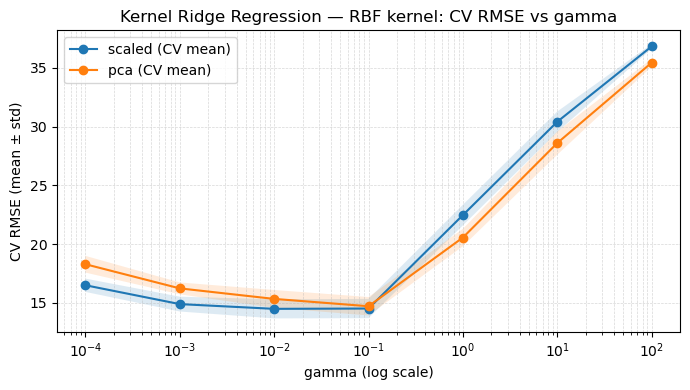

Saved KRR CV Curve: C:\Users\dirkv\OneDrive\Documents\Delft\MSc_CS\Year1\EOSL\final_project_repo\results\figures\kernel_ridge_regression\krr_cv_rmse_vs_gamma_rbf.png


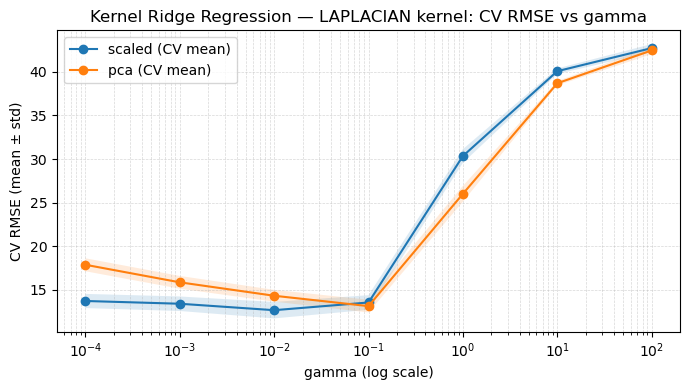

Saved KRR CV Curve: C:\Users\dirkv\OneDrive\Documents\Delft\MSc_CS\Year1\EOSL\final_project_repo\results\figures\kernel_ridge_regression\krr_cv_rmse_vs_gamma_laplacian.png


In [8]:
# Plot CV curves for KRR: RMSE vs gamma (log scale), by kernel with PCA/no-PCA overlay

def plot_krr_cv_curves(cv_curves, kernel_name):
    """
    Plots the cross-validation RMSE vs gamma for Kernel Ridge Regression.
    Mirrors the style used in Local Regression results.
    """
    fig, ax = plt.subplots(figsize=(7, 4))

    # Iterate through the data representations to create overlays
    for rep in ["scaled", "pca"]:
        if (rep, kernel_name) in cv_curves:
            df = cv_curves[(rep, kernel_name)].sort_values("gamma")
            
            # Plot the mean CV RMSE across folds
            ax.plot(df["gamma"], df["cv_rmse_mean"], marker="o", label=f"{rep} (CV mean)")
            
            # Add the error band representing mean ± standard deviation
            ax.fill_between(df["gamma"],
                            df["cv_rmse_mean"] - df["cv_rmse_std"],
                            df["cv_rmse_mean"] + df["cv_rmse_std"],
                            alpha=0.15)

    # Format the plot to match project standards
    ax.set_xscale("log")
    ax.set_xlabel("gamma (log scale)")
    ax.set_ylabel("CV RMSE (mean ± std)")
    ax.set_title(f"Kernel Ridge Regression — {kernel_name.upper()} kernel: CV RMSE vs gamma")
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

    fig.tight_layout()
    return fig

# Generate and save the plots for RBF and Laplacian kernels
for kname in ["rbf", "laplacian"]:
    # Ensure FIG_DIR exists before saving
    fig = plot_krr_cv_curves(krr_cv_plotting, kname)
    fig_path = FIG_DIR / f"krr_cv_rmse_vs_gamma_{kname}.png"
    fig.savefig(fig_path, dpi=200)
    plt.show()
    print(f"Saved KRR CV Curve: {fig_path}")

<Figure size 1200x600 with 0 Axes>

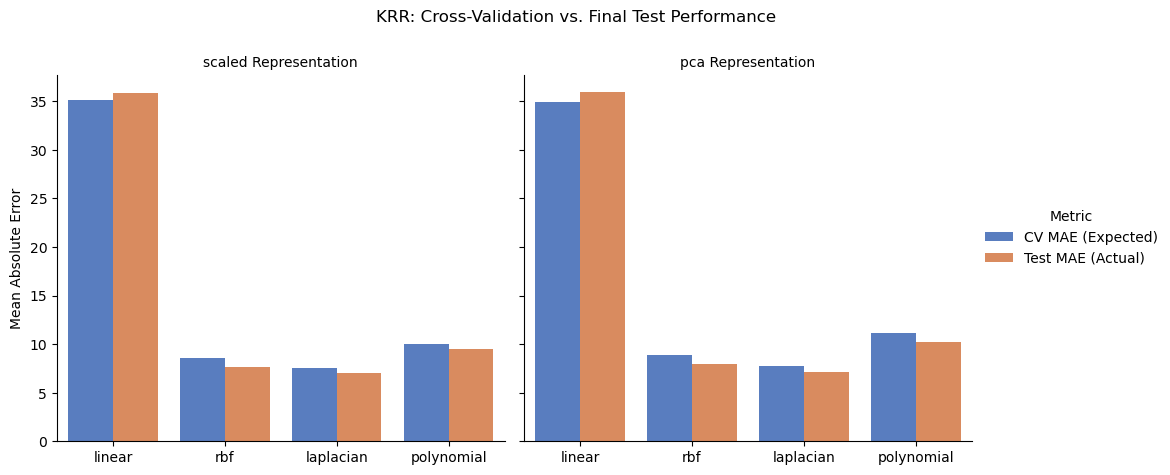

In [ ]:
import seaborn as sns

def plot_cv_vs_test_comparison(results_df):
    # Reshape the data for side-by-side plotting
    df_melted = results_df.melt(
        id_vars=['kernel', 'representation'], 
        value_vars=['cv_mae_mean_at_best', 'test_mae'],
        var_name='Metric', value_name='MAE'
    )
    
    # Rename labels for the legend
    df_melted['Metric'] = df_melted['Metric'].replace({
        'cv_mae_mean_at_best': 'CV MAE (Expected)',
        'test_mae': 'Test MAE (Actual)'
    })

    plt.figure(figsize=(12, 6))
    
    # Split by representation (Scaled vs PCA) using
    # This creates two plots side-by-side
    g = sns.catplot(
        data=df_melted, kind="bar",
        x="kernel", y="MAE", hue="Metric",
        col="representation", palette="muted", height=5
    )
    
    g.set_axis_labels("", "Mean Absolute Error")
    g.set_titles("{col_name} Representation")
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('KRR: Cross-Validation vs. Final Test Performance')
    
    plt.savefig(FIG_DIR / "krr_cv_vs_test_comparison.png", dpi=200)
    plt.show()

plot_cv_vs_test_comparison(df_results)

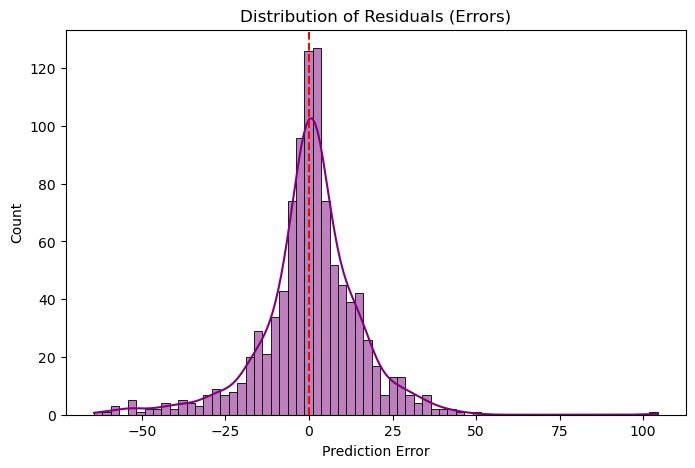

In [15]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, color='purple')
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Distribution of Residuals (Errors)")
    plt.xlabel("Prediction Error")
    plt.savefig(FIG_DIR / "krr_residuals.png")
    plt.show()

plot_residuals(y_test, test_preds)